<h1><center>GANdido Portinari - Neural Style Transfer com CycleGANs</center></h1>

<center><img src="imgs/capa.jpg"></center>

# Sumário

* [1. Introdução](#1.-Introdução)
* [2. Metodologia](#2.-Metodologia)
* [3. Desenvolvimento](#3.-Desenvolvimento)
* [4. Resultados](#4.-Resultados)
* [5. Referências](#5.-Referências)

# 1. Introdução

O nosso trabalho tem como foco principal a utilização e implementação de GANs, mais especificamente a CycleGAN. GANs são uma arquitetura para treinar modelos generativos, como redes neurais convolucionais profundas e possuem diversas aplicações como geração de imagens, vídeos, textos e algumas outras. A aplicação de GANs nesse trabalhou consistiu na geração de imagens baseadas nas obras de Candido Portinari, que foi um importante artista plástico brasileiro da fase modernista com reconhecimento mundial. A arquitetura GAN é composta por um gerador e um modelo discriminador. O gerador é responsável por criar novas saídas que podem ser imagens reais  —que neste trabalho foram imagens. E o modelo discriminador é o responsável por classificar as imagens do gerador, a partir de uma database com imagens reais. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
#from losses import discriminator_loss, generator_loss, calc_cycle_loss, identity_loss
#from generator import Generator
#from discriminator import Discriminator
#from data_generator import load_dataset
#from cycleGAN import CycleGan
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available


<h2>2.Metodologia</h2>

<p>&emsp;Os dados usados neste projeto foram  imagens obtidas a partir de um simples script de request do próprio site do 
Portinari que pode ser encontrado nas referências. Foram usadas cerca de cinco mil obras. Para o processamento
dos dados houve necessidade de padronizar o tamanho das imagens para entrada na rede 
para o tamanho 256x256, e após isso o treinamento da CycleGAN.
</p>
<p>

## Entrada dos Dados

In [ ]:
GANDIDO_FILENAMES = tf.io.gfile.glob('gandido/*.jpeg')
print('Gandido Files:', len(GANDIDO_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo/*.jpeg')
print('Photo Files:', len(PHOTO_FILENAMES))

Gandido Files: 4580
Photo Files: 7947


In [ ]:
IMAGE_SIZE = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/127.5) - 1
    
    image = tf.image.resize(image, IMAGE_SIZE,
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = tf.reshape(image, [*IMAGE_SIZE,3])

    return image

def process(example):
    img = tf.io.read_file(example)

    image = decode_image(img)
    return image

In [ ]:
def load_dataset(img_path, labeled=True, ordered=False):
    dataset = tf.data.Dataset.list_files(img_path)
    dataset = dataset.map(lambda x: process(x))
    return dataset

In [ ]:
candido_datagen = tf.data.Dataset.list_files("./gandido/*.jpeg")
photo_datagen = tf.data.Dataset.list_files("./photo/*.jpeg")


candido_ds = candido_datagen.map(lambda x: process(x)).batch(4)

photo_ds = photo_datagen.map(lambda x: process(x)).batch(4)

In [ ]:
example_candido = next(iter(candido_ds))
example_photo = next(iter(photo_ds))

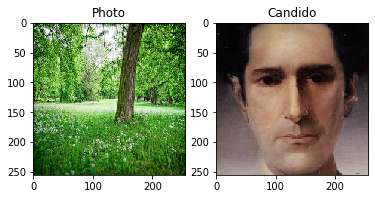

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Candido')
plt.imshow(example_candido[0]* 0.5 + 0.5)

## Implementação do Downsample e Upsample

<b>2.1 Camada Downsample</b><br/>
&emsp;A camada Downsample foi necessária para padronização dos tamanhos das imagens. A função recebe como parâmetros
o filters, size e instancenorm. O parâmetro filters informa quantos filtros
serão usados, o size informa qual será o shape desses filtros e o instancenorm é uma flag que indica se será
usada uma instância normalizada ou não.
</p>

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

<b>2.1 Camada Upsample</b><br/>
&emsp;A camada Upsample foi utilizada como forma de aumentar as imagens para garantir uma maior amostragem, diferentemente do downsample. Além disso, ela usa a função ```Conv2DTranspose()```. A função recebe como parâmetros
o filters, size e uma flag que indica a utilização ou não de Dropout. O parâmetro filters informa quantos filtros serão usados, o size informa qual será o shape desses filtros.
</p>

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Implementação do Generator

<p>Abaixo temos a implementação da função Generator,que será usado como modelo para criação dos objetos responsáveis 
por criar as imagens com estilo de Portinari e por passar uma visão mais realista à alguma obra ou rascunho de
Portinari, como veremos futuramente. Nela temos a utilização de várias camadas de upsample e de downsample 
sendo concatenadas. A função recebe como input uma imagem e trata ela a partir da função downsample já mencionada
anteriormente.
</p>

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Implementação do Discriminator
O discriminator será a função responsável por criar os objetos que servirão para identificar se uma imagem faz 
parte de uma distribuição ou não. No nosso modelo CycleGan, por exemplo, teremos dois discriminators.
Um destes objetos será responsável por distinguir se uma imagem se assemelha às obras de Portinari ou não.
Enquanto o outro servirá para dizer se uma imagem é real ou uma obra de arte. O discriminator recebe os dados
a partir do generator,podendo ser imagens reais ou falsas(geradas) e também a partir de um banco de dados
com as imagens reais(do domínio) para fazer a classificação.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

## CycleGan
Nesta seção temos a implementação do nosso modelo CycleGan a partir da função keras.Model, servindo como *blueprint*. É possível ver projetos diferentes implementados a partir dessa rede [nesse link](https://junyanz.github.io/CycleGAN/). Para um aprofundamento teórico, é possível ler o [paper sobre a implementação da rede no arxiv](https://arxiv.org/pdf/1703.10593.pdf).

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        candido_generator,
        photo_generator,
        candido_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = candido_generator
        self.p_gen = photo_generator
        self.m_disc = candido_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_candido, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to candido back to photo
            fake_candido = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_candido, training=True)

            # candido to photo back to candido
            fake_photo = self.p_gen(real_candido, training=True)
            cycled_candido = self.m_gen(fake_photo, training=True)

            # generating itself
            same_candido = self.m_gen(real_candido, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_candido = self.m_disc(real_candido, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_candido = self.m_disc(fake_candido, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            candido_gen_loss = self.gen_loss_fn(disc_fake_candido)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_candido, cycled_candido, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_candido_gen_loss = candido_gen_loss + total_cycle_loss + self.identity_loss_fn(real_candido, same_candido, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            candido_disc_loss = self.disc_loss_fn(disc_real_candido, disc_fake_candido)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        candido_generator_gradients = tape.gradient(total_candido_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        candido_discriminator_gradients = tape.gradient(candido_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(candido_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(candido_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "candido_gen_loss": total_candido_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "candido_disc_loss": candido_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Losses
* Aqui listaremos as métricas que serão utilizadas para execução de nosso código

###### Discriminator loss

 A função de perda do descriminador compara uma imagem real à uma matriz de números 1 de mesmo formato. A função compara também as imagens geradas (fakes) à uma matriz de zeros, também de mesmo formato. Como output, a rede retorna a média entre essas duas perdas geradas.

In [ ]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

###### Generator loss
O gerador tenta "enganar" o discriminador, tentando passar uma imagem gerada como real. O gerador perfeito terá como saída num discriminador apenas números 1, indicando que a imagem passou como real. Então ele compara a imagem gerada com uma matriz de uns de mesmo formato para encontrar a perda.

In [ ]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

###### Cycle loss
Como queremos que nossa foto original e a foto transformada duas vezes sejam similares uma com a outra, calculamos a consistência do ciclo encontrando a média da diferença entre os pixels dessas duas imagens fornecidas.

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

###### Identity loss
A função de perda da identidade compara a imagem com o gerador dela. Dada uma imagem como exemplo, queremos gerar a mesma imagem a partir do gerador. Essa função de perda compara o input dado - nesse caso uma foto -, com a saída do gerador para essa mesma. 

In [ ]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Definição do modelo

In [ ]:
gandido_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gandido_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
gandido_generator = Generator()
photo_generator = Generator()

In [ ]:
gandido_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [ ]:
cycle_gan_model = CycleGan(
    gandido_generator, photo_generator, gandido_discriminator, photo_discriminator
)

In [ ]:
cycle_gan_model.compile(
    gandido_generator_optimizer,
    photo_generator_optimizer,
    gandido_discriminator_optimizer,
    photo_discriminator_optimizer,
    generator_loss,
    discriminator_loss,
    calc_cycle_loss,
    identity_loss
)

## Treino e Resultados
Nosso treinamento demorou aproximadamente 6 horas e mostraremos em seguida as imagens resultantes de nosso trabalho

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((candido_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
1145/1145 [==============================] - 740s 646ms/step - candido_gen_loss: 4.1788 - photo_gen_loss: 4.3616 - candido_disc_loss: 0.5066 - photo_disc_loss: 0.5105
Epoch 2/25
1145/1145 [==============================] - 780s 682ms/step - candido_gen_loss: 3.7189 - photo_gen_loss: 3.8096 - candido_disc_loss: 0.4956 - photo_disc_loss: 0.5341
Epoch 3/25
1145/1145 [==============================] - 789s 689ms/step - candido_gen_loss: 3.9402 - photo_gen_loss: 3.7772 - candido_disc_loss: 0.4423 - photo_disc_loss: 0.5433
Epoch 4/25
1145/1145 [==============================] - 794s 694ms/step - candido_gen_loss: 4.0950 - photo_gen_loss: 3.7662 - candido_disc_loss: 0.3989 - photo_disc_loss: 0.5295
Epoch 5/25
1145/1145 [==============================] - 795s 694ms/step - candido_gen_loss: 4.0712 - photo_gen_loss: 3.6533 - candido_disc_loss: 0.3888 - photo_disc_loss: 0.5351
Epoch 6/25
1145/1145 [==============================] - 796s 695ms/step - candido_gen_loss: 4.0642 - photo_gen

In [ ]:
j = 0

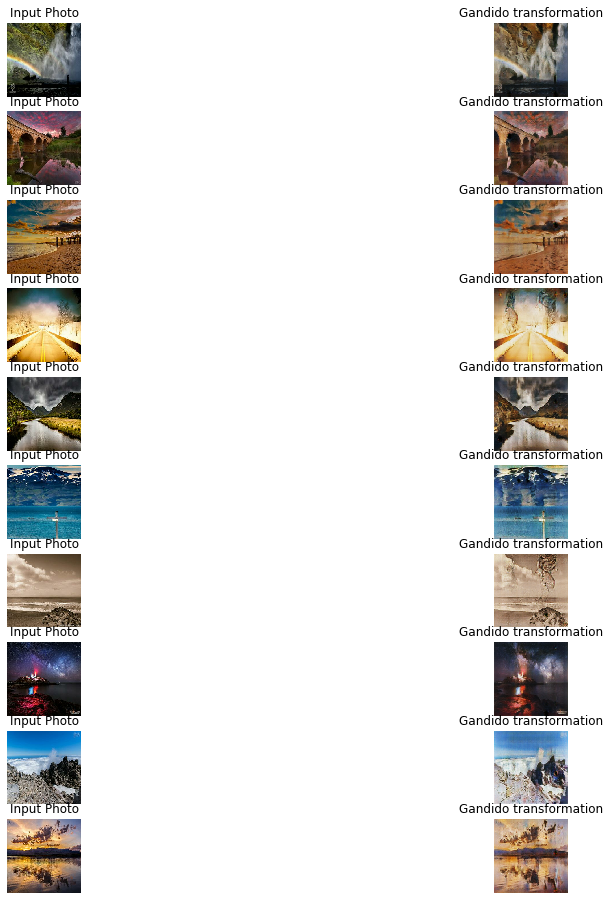

In [ ]:
_, ax = plt.subplots(10, 2, figsize=(16, 16))
for i, img in enumerate(photo_ds.take(10)):
    prediction = gandido_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Gandido transformation")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    plt.imsave(f'output/prediction_{i+j}_original.jpg', img)
    plt.imsave(f'output/prediction_{i+j}.jpg', prediction)
j += 10
plt.show()

In [ ]:
gandido_generator.save("gandido_generator.h5")

## Melhores resultados

### 1. Generator de Portinari

| Input                                   |                      Output     |
|:---------------------------------------:|:-------------------------------:|
| ![](examples/portinari_generator/prediction_4_original.jpg) |  ![](examples/portinari_generator/prediction_4.jpg) |
| ![](examples/portinari_generator/prediction_5_original.jpg) |  ![](examples/portinari_generator/prediction_5.jpg) |
| ![](examples/portinari_generator/prediction_13_original.jpg)|  ![](examples/portinari_generator/prediction_13.jpg)|
| ![](examples/portinari_generator/prediction_17_original.jpg)|  ![](examples/portinari_generator/prediction_17.jpg)|
| ![](examples/portinari_generator/prediction_18_original.jpg)|  ![](examples/portinari_generator/prediction_18.jpg)|
| ![](examples/portinari_generator/prediction_35_original.jpg)|  ![](examples/portinari_generator/prediction_35.jpg)|
| ![](examples/portinari_generator/prediction_45_original.jpg)|  ![](examples/portinari_generator/prediction_45.jpg)|
| ![](examples/portinari_generator/prediction_47_original.jpg)|  ![](examples/portinari_generator/prediction_47.jpg)|
| ![](examples/portinari_generator/prediction_48_original.jpg)|  ![](examples/portinari_generator/prediction_48.jpg)|

### 2. Generator de fotos reais

| Input                                   |                      Output     |
|:---------------------------------------:|:-------------------------------:|
| ![](examples/foto_generator/prediction_0_original.jpg) |  ![](examples/foto_generator/prediction_0.jpg) |
| ![](examples/foto_generator/prediction_97_original.jpg) |  ![](examples/foto_generator/prediction_97.jpg) |
| ![](examples/foto_generator/prediction_134_original.jpg) |  ![](examples/foto_generator/prediction_134.jpg) |